# Занятие 2: Практика по Линейной и Полиномиальной Регрессия

## Загружаем библиотеки

In [101]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import requests
import csv
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

from scipy import stats
from scipy.interpolate import interp1d
from scipy import optimize

## Загружаем и анализируем датасет о пожизненной ценности клиента

In [102]:
data_file = "../data/Telco_customer_churn_2020.csv"
df = pd.read_csv(data_file, encoding = "utf-8" , engine='python')
print(df.columns)

# уберем проблемные значения
df = df.dropna()

# переведем важную колонку из строчки в числа
df['Total Charges'] = [float(val) for val in df['Total Charges'].values]

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')


In [103]:
# Оставим только числа
num_cols = [col for col in df.columns.values if is_numeric_dtype(df[col])]
df = df[num_cols]
df = df.astype(float)

print(df.columns)

Index(['Count', 'Zip Code', 'Latitude', 'Longitude', 'Tenure Months',
       'Monthly Charges', 'Total Charges', 'Churn Value', 'Churn Score',
       'CLTV'],
      dtype='object')


In [104]:
print(df.columns)

Index(['Count', 'Zip Code', 'Latitude', 'Longitude', 'Tenure Months',
       'Monthly Charges', 'Total Charges', 'Churn Value', 'Churn Score',
       'CLTV'],
      dtype='object')


In [105]:
for col in df.columns.values:
    print(col, " corr: ", df[col].corr(df['CLTV']))

Count  corr:  nan
Zip Code  corr:  -0.026054629355475093
Latitude  corr:  -0.006255284756153498
Longitude  corr:  0.021714936403374924
Tenure Months  corr:  0.2192211654007938
Monthly Charges  corr:  0.05497099072808285
Total Charges  corr:  0.2186438046223449
Churn Value  corr:  nan
Churn Score  corr:  0.017190691005270837
CLTV  corr:  1.0


In [106]:
df = pd.concat([df["Total Charges"], df["CLTV"]], axis=1)

### Визуализируем данные

No handles with labels found to put in legend.


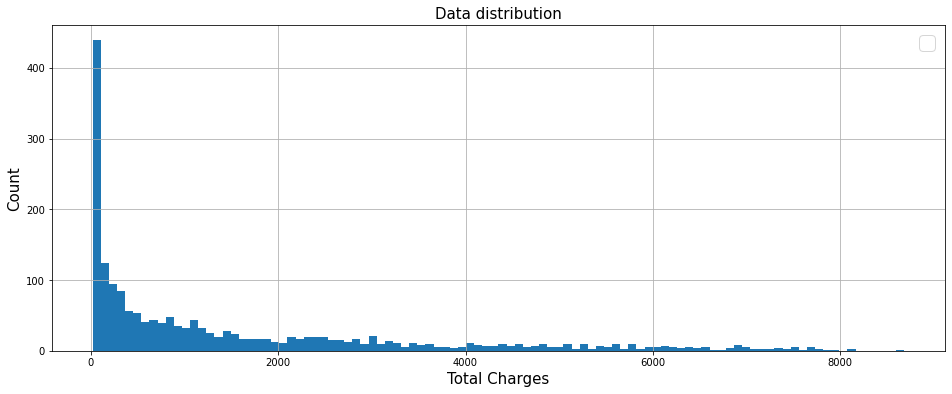

In [107]:
df['Total Charges'].hist(bins=100, figsize=(16,6))
plt.title('Data distribution', fontsize=15)
plt.xlabel('Total Charges', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(fontsize=20)
plt.show()

No handles with labels found to put in legend.


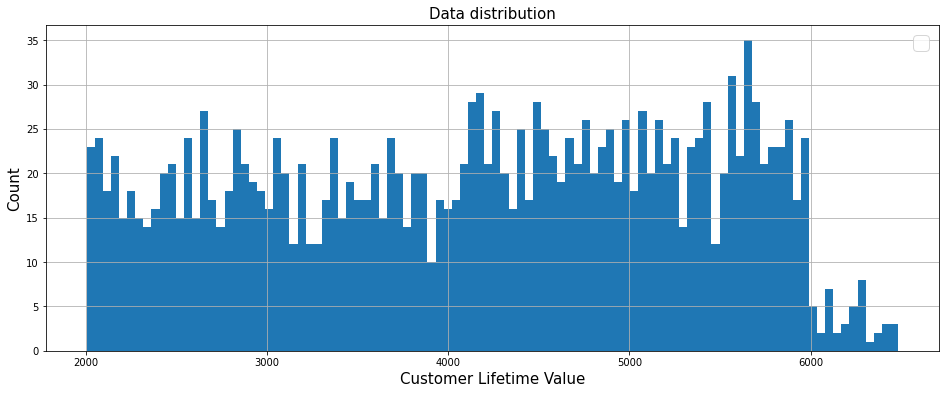

In [108]:
df['CLTV'].hist(bins=100, figsize=(16,6))
plt.title('Data distribution', fontsize=15)
plt.xlabel('Customer Lifetime Value', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(fontsize=20)
plt.show()

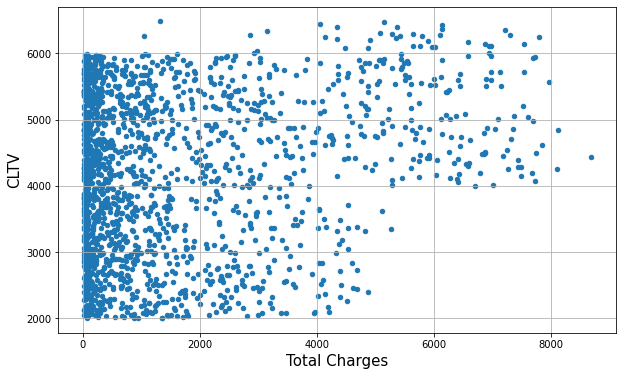

In [109]:
df.plot.scatter('Total Charges', 'CLTV', figsize=(10,6))
plt.xlabel('Total Charges', fontsize=15)
plt.ylabel('CLTV', fontsize=15)
plt.grid()

## Разделяем дата на выборки

In [110]:
x_data = np.expand_dims(df['Total Charges'].values, axis=1)
y_data = np.expand_dims(df['CLTV'].values, axis=1)

# 20% данных будем использовать как validation dataset
val_size = 0.2

X_train, X_val, y_train, y_val = train_test_split(x_data, y_data, test_size=val_size, shuffle=True)
print('Data points in train set: {0}.'.format(len(X_train)))
print('Data points in val set: {0}.'.format(len(X_val)))
print("Shape of features in training data: {}".format(X_train.shape))
print("Shape of output in training data: {}".format(y_train.shape))
print("Shape of features in val data: {}".format(X_val.shape))
print("Shape of output in val data: {}".format(y_val.shape))

Data points in train set: 1495.
Data points in val set: 374.
Shape of features in training data: (1495, 1)
Shape of output in training data: (1495, 1)
Shape of features in val data: (374, 1)
Shape of output in val data: (374, 1)


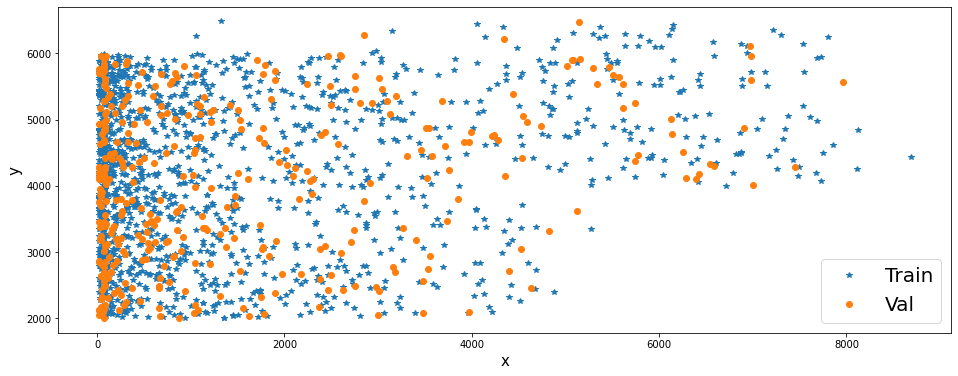

In [111]:
# Посмотрить показательный ли validation dataset
plt.figure(figsize=(16,6))
plt.plot(X_train, y_train, '*', label='Train')
plt.plot(X_val, y_val, 'o', label='Val')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=20)
plt.show()

## Применяем линейную регрессию

In [112]:
reg = LinearRegression().fit(X_train, y_train)

# Считаем Коэффициент детерминации
# https://en.wikipedia.org/wiki/Coefficient_of_determination
print("Regression R2 score on the train data: ", reg.score(X_train, y_train))
print("Regression R2 score on the val data: ", reg.score(X_val, y_val))



Regression R2 score on the train data:  0.04544121334258111
Regression R2 score on the val data:  0.04416454318670748


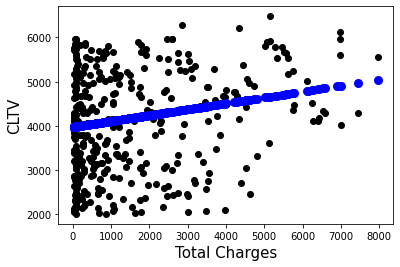

In [113]:
# Предсказываем
load_y_pred = reg.predict(X_val)

# Визуализируем
plt.scatter(X_val, y_val,  color='black')
plt.scatter(X_val, load_y_pred, color='blue', linewidth=3)

plt.xlabel('Total Charges', fontsize=15)
plt.ylabel('СLTV', fontsize=15)

plt.show()

## Применяем полиномиальную регрессию

Coefficient of determination: 0.050


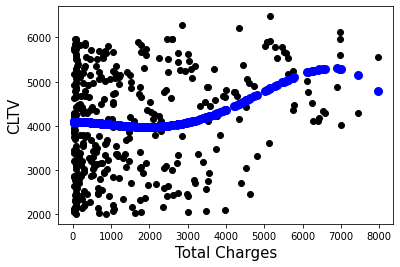

In [115]:
# Задаем степень полинома
polynomial_degree = 5

# Описиваем полиномиальную регрессию
polyreg = make_pipeline(
        PolynomialFeatures(degree=polynomial_degree),
        LinearRegression()
        )

# Находим коефициенты
polyreg.fit(X_train, y_train)

# Предсказываем
ploy_load_pred = polyreg.predict(X_val)


# Считаем коэффициент детерминации
# https://en.wikipedia.org/wiki/Coefficient_of_determination
print('Coefficient of determination: %.3f'
      % r2_score(y_val, ploy_load_pred))

# Визуализируем
plt.scatter(X_val, y_val,  color='black')
plt.scatter(X_val, ploy_load_pred, color='blue', linewidth=3)

plt.xlabel('Total Charges', fontsize=15)
plt.ylabel('СLTV', fontsize=15)

plt.show()

## Используем много фич на вход

In [116]:
# Загрузим датасет еще раз
data_file = "../data/Telco_customer_churn_2020.csv"
df = pd.read_csv(data_file, encoding = "utf-8" , engine='python')

# уберем проблемные значения
df = df.dropna()

# переведем важную колонку из строчки в числа
df['Total Charges'] = [float(val) for val in df['Total Charges'].values]

## Используем несколько фич на вход
num_cols = [col for col in df.columns.values if is_numeric_dtype(df[col])]
df = df[num_cols]
df = df.astype(float)

print(df.columns)

Index(['Count', 'Zip Code', 'Latitude', 'Longitude', 'Tenure Months',
       'Monthly Charges', 'Total Charges', 'Churn Value', 'Churn Score',
       'CLTV'],
      dtype='object')


In [117]:
df_x = df.drop('CLTV', axis=1)
x_data = df_x.values
y_data = np.expand_dims(df['CLTV'].values, axis=1)

# Убрать outlier
df = df[(z < threshold).all(axis=1)]

# Проверим Размерность
print(x_data.shape)
print(y_data.shape)

## Разделяем дата на выборки
val_size = 0.2

X_train, X_val, y_train, y_val = train_test_split(x_data, y_data, test_size=val_size, shuffle=True)

(1869, 9)
(1869, 1)


(1495, 9)


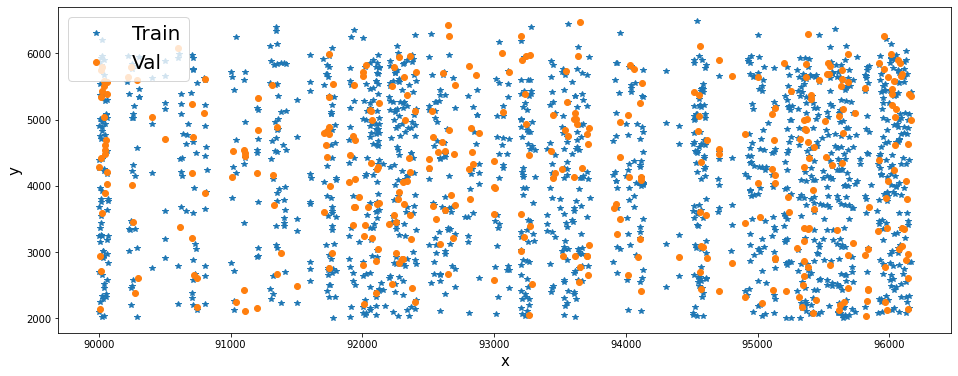

In [118]:
# Посмотрим показательный ли validation dataset

print(X_train.shape)
plt.figure(figsize=(16,6))
plt.plot(X_train[:,1], y_train, '*', label='Train')
plt.plot(X_val[:,1], y_val, 'o', label='Val')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=20)
plt.show()

Coefficient of determination: -0.029


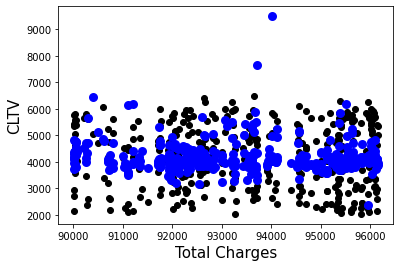

In [121]:
# Задаем степень полинома
polynomial_degree = 3

# Описиваем полиномиальную регрессию
polyreg = make_pipeline(
        PolynomialFeatures(degree=polynomial_degree),
        LinearRegression()
        )

# Находим коефициенты
polyreg.fit(X_train, y_train)

# Предсказываем
ploy_load_pred = polyreg.predict(X_val)


# Считаем коэффициент детерминации
# https://en.wikipedia.org/wiki/Coefficient_of_determination
print('Coefficient of determination: %.3f'
      % r2_score(y_val, ploy_load_pred))

# Визуализируем
plt.scatter(X_val[:,1], y_val,  color='black')
plt.scatter(X_val[:,1], ploy_load_pred, color='blue', linewidth=3)

plt.xlabel('Total Charges', fontsize=15)
plt.ylabel('СLTV', fontsize=15)

plt.show()

## Используем меньше фич на вход

In [122]:
# Загрузим датасет еще раз
data_file = "../data/Telco_customer_churn_2020.csv"
df = pd.read_csv(data_file, encoding = "utf-8" , engine='python')

# уберем проблемные значения
df = df.dropna()

# переведем важную колонку из строчки в числа
df['Total Charges'] = [float(val) for val in df['Total Charges'].values]

## Используем несколько фич на вход
df_x = pd.concat([ df['Total Charges'], df['Tenure Months']], axis=1).dropna()
x_data = df_x.values
y_data = np.expand_dims(df['CLTV'].values, axis=1)

# Убрать outlier
df = df[(z < threshold).all(axis=1)]

# Проверим Размерность
print(x_data.shape)
print(y_data.shape)

## Разделяем дата на выборки
val_size = 0.2

X_train, X_val, y_train, y_val = train_test_split(x_data, y_data, test_size=val_size, shuffle=True)

(1869, 2)
(1869, 1)


Coefficient of determination: 0.11


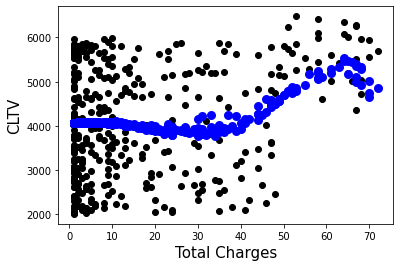

In [123]:
# Задаем степень полинома
polynomial_degree = 5

# Описиваем полиномиальную регрессию
polyreg = make_pipeline(
        PolynomialFeatures(degree=polynomial_degree),
        LinearRegression()
        )

# Находим коефициенты
polyreg.fit(X_train, y_train)

# Предсказываем
ploy_load_pred = polyreg.predict(X_val)


# Считаем коэффициент детерминации
# https://en.wikipedia.org/wiki/Coefficient_of_determination
print('Coefficient of determination: %.2f'
      % r2_score(y_val, ploy_load_pred))

# Визуализируем
plt.scatter(X_val[:,1], y_val,  color='black')
plt.scatter(X_val[:,1], ploy_load_pred, color='blue', linewidth=3)

plt.xlabel('Total Charges', fontsize=15)
plt.ylabel('СLTV', fontsize=15)

plt.show()

In [100]:
# На этом сегодня все